In [1]:
import os

import jax.numpy as jnp
import jax.random as jr
import jaxtyping
import optax
import pandas as pd
import seaborn.objects as so
import matplotlib.pyplot as plt
import inspect
import matplotlib as mpl
import seaborn as sns


with jaxtyping.install_import_hook(["cnpe", "cnpe_validation"], "beartype.beartype"):
    from cnpe import losses
    from cnpe.train import train

    from cnpe_validation.tasks.multimodal_gaussian import (
        MultimodelGaussianWellSpecifiedGuideTask,
    )
    from cnpe_validation.utils import get_abspath_project_root

os.chdir(get_abspath_project_root())

In [2]:
key, subkey = jr.split(jr.PRNGKey(3))

vi_steps= 20000
maximum_likelihood_steps = 10000
contrastive_steps = 10000
num_contrastive = 20

task = MultimodelGaussianWellSpecifiedGuideTask(subkey)

key, subkey = jr.split(key)
true_latents, obs = task.get_latents_and_observed_and_validate(subkey)

posteriors = {}
optimizer = optax.adam(optax.linear_schedule(1e-2, 1e-3, maximum_likelihood_steps))

# Train using VI
method_name = "ELBO"
loss = losses.NegativeEvidenceLowerBound(task.model.reparam(set_val=True), obs=obs)

key, subkey = jr.split(key)
posteriors[method_name], _ = train(
    subkey,
    guide=task.guide,
    loss_fn=loss,
    steps=vi_steps,
    optimizer=optimizer,
)

# Train using maximum likelihood
loss = losses.AmortizedMaximumLikelihood(task.model.reparam(set_val=True))

ml_posterior, _ = train(
    subkey,
    guide=task.guide,
    loss_fn=loss,
    steps=maximum_likelihood_steps,
    optimizer=optimizer,
)

optimizer = optax.apply_if_finite(
        optax.adam(optax.linear_schedule(1e-2, 1e-3, maximum_likelihood_steps)),
    max_consecutive_errors=100,
)

# # Fine tune with contrastive loss
method_name = "NPE-PP"
loss = losses.ContrastiveLoss(
    model=task.model.reparam(),
    obs=obs,
    n_contrastive=num_contrastive,
    stop_grad_for_contrastive_sampling=False,
)

key, subkey = jr.split(key)

posteriors[method_name], _ = train(
    subkey,
    guide=ml_posterior,
    loss_fn=loss,
    steps=contrastive_steps,
    optimizer=optimizer,
)


100%|██████████| 10000/10000 [01:26<00:00, 115.92it/s, loss=3.55]  


In [66]:
# https://github.com/mwaskom/seaborn/issues/3247
def move_legend_fig_to_ax(fig, ax, loc, bbox_to_anchor=None, **kwargs):
    if fig.legends:
        old_legend = fig.legends[-1]
    else:
        raise ValueError("Figure has no legend attached.")

    old_boxes = old_legend.get_children()[0].get_children()

    legend_kws = inspect.signature(mpl.legend.Legend).parameters
    props = {
        k: v for k, v in old_legend.properties().items() if k in legend_kws
    }

    props.pop("bbox_to_anchor")
    title = props.pop("title")
    if "title" in kwargs:
        title.set_text(kwargs.pop("title"))
    title_kwargs = {k: v for k, v in kwargs.items() if k.startswith("title_")}
    for key, val in title_kwargs.items():
        title.set(**{key[6:]: val})
        kwargs.pop(key)
    kwargs.setdefault("frameon", old_legend.legendPatch.get_visible())

    # Remove the old legend and create the new one
    props.update(kwargs)
    fig.legends = []
    new_legend = ax.legend(
        [], [], loc=loc, bbox_to_anchor=bbox_to_anchor, **props,
    )
    new_legend.get_children()[0].get_children().extend(old_boxes)

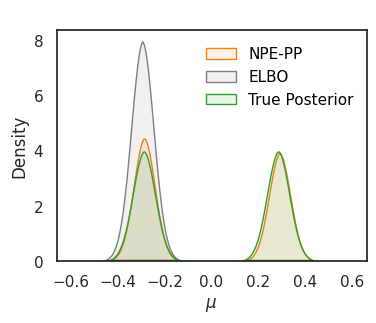

In [95]:

distributions = {
    k: posterior.mu.to_dist(obs["x"]) for k, posterior in posteriors.items()
} | {"True Posterior": task.model.get_true_posterior(obs)}

mu = jnp.linspace(-0.6, 0.6, 500)

densities = {
    k: jnp.exp(dist.log_prob(mu)) for k, dist in distributions.items()
}
df = pd.DataFrame(
    densities | {"mu": mu},
    ).melt(id_vars="mu", value_name="Density", var_name="Distribution")


palette = {
    "NPE-PP":  "tab:orange",
    "ELBO": "tab:grey",
    "True Posterior":  "tab:green",
}

df["Distribution"] = pd.Categorical(
    df["Distribution"], categories=palette.keys(),
)
so.Plot.config.theme.update(sns.axes_style("white"))

p = so.Plot(
    df,
    x="mu",
    y="Density",
    color="Distribution",
).add(so.Area(alpha=0.1)).label(x=r"$\mu$").scale(color=palette)

fig = plt.figure()
res = p.on(fig).plot()
ax = fig.axes[0]
move_legend_fig_to_ax(fig, ax, loc=1, bbox_to_anchor=(1, 1.12), title=None)
ax.get_legend().set_title(None)
ax.get_legend().get_frame().set_alpha(0)
fig.set_size_inches(4, 3)
fig.savefig("plots/mass_covering.pdf", bbox_inches="tight")
